## <font color='aqua'> This will be a Bispectra Theory Comparison to confirm that the Bispectrum Calculator works. </font>

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import healpy as hp
import pickle
import numba as nb
import spherical
import numba_progress
import math
import scipy

from tqdm.notebook import tqdm
from spherical import Wigner3j
from numba import jit, njit, prange, set_num_threads
from numba_progress import ProgressBar
from scipy import stats

from helper_funcs import *

In [2]:
lmax = 1000

ells = np.arange(lmax+1)

cls = np.zeros_like(ells, dtype='float')

for l in ells:
    if l == 0:
        cls[l] = 0
    else:
        cls[l] = (l+0.0)**(-3.)

0.0 180.0 -180.0 180.0


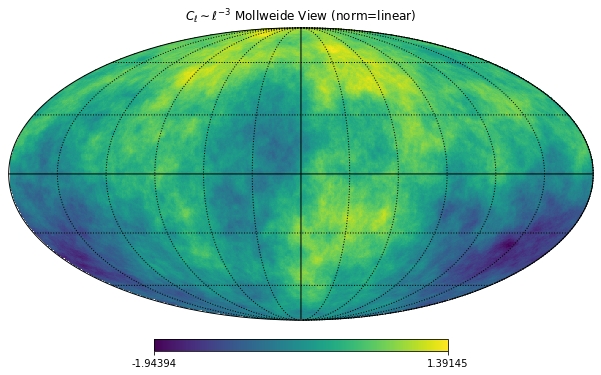

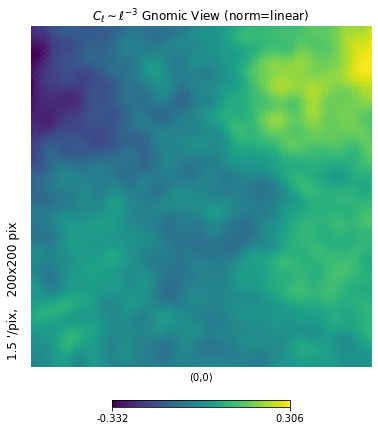

In [3]:
theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=np.max(ells), alm=True)

hp.mollview(theory_map, title='$C_{\ell} \sim {\ell}^{-3}$ Mollweide View (norm=linear)')
hp.graticule()

hp.gnomview(theory_map, title='$C_{\ell} \sim {\ell}^{-3}$ Gnomic View (norm=linear)')

In [4]:
ana_cls = hp.anafast(theory_map, lmax=lmax)
sorted_alms = sort_alms(alms, len(cls))
computed_cls = compute_cls(sorted_alms)
print(len(cls), len(ana_cls), len(computed_cls))

1001 1001 1001


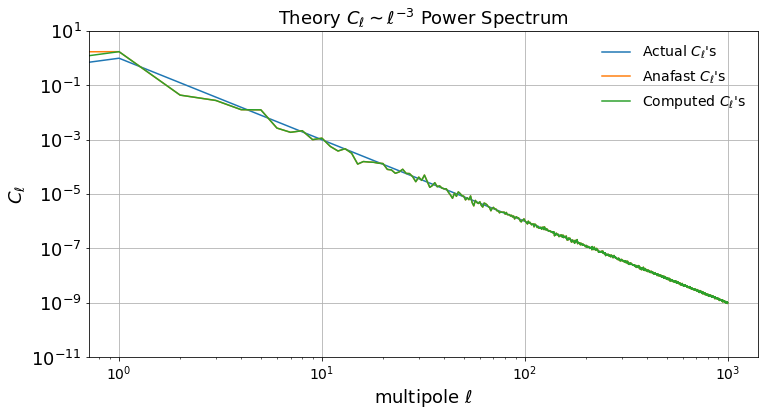

In [5]:
cls_list = [cls, ana_cls, computed_cls]
cls_labels = ["Actual $C_{\ell}$'s", "Anafast $C_{\ell}$'s", "Computed $C_{\ell}$'s"]

plot_cl(ells, cls_list, labels=cls_labels, ylim=(1e-11,1e1), title="Theory $C_{\ell} \sim \ell^{-3}$ Power Spectrum")

/tmp/ipykernel_24794/2514389750.py:1: RuntimeWarning: invalid value encountered in true_divide
  frac_residual = (computed_cls - cls) / (cls)


Text(0.5, 1.0, "(Computed $C_{\\ell}$'s - $\\ell^{-3}$) / $\\ell^{-3}$")

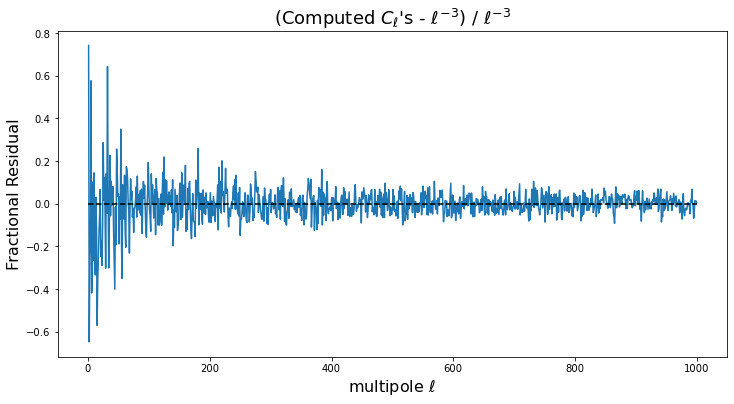

In [6]:
frac_residual = (computed_cls - cls) / (cls)

plt.figure(figsize=(12,6))
plt.plot(ells, frac_residual)
plt.plot(ells, np.zeros_like(ells),'k--')
plt.xlabel("multipole $\ell$", fontsize=16)
plt.ylabel("Fractional Residual", fontsize=16)
plt.title("(Computed $C_{\ell}$'s - $\ell^{-3}$) / $\ell^{-3}$", fontsize=18)

In [7]:
# find_stats(theory_map, hp_map=True)

In [8]:
nside = hp.get_nside(theory_map)

pix_area = hp.nside2pixarea(nside)

# precise estimate for the overdensity

delta = theory_map*pix_area / np.mean(theory_map*pix_area) - 1

We have:

$$ B_{\ell_1\ell_2\ell_3} = \sqrt{N_{\Delta}^{\ell_1\ell_2\ell_3}} \sum_{m_1,m_2,m_3} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    m_1 & m_2 & m_3
\end{pmatrix} \langle a_{\ell_1 m_1} a_{\ell_2 m_2} a_{\ell_3 m_3} \rangle $$

such that:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2

**Bispectrum Templates:**

For local $f_{\rm NL}$ potential, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + f_{\rm NL} \left(\phi_{\rm Gauss}^2 - \langle\phi_{\rm Gauss}\rangle^2\right) $$

For $g_{\rm NL}$, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + g_{\rm NL}\left(\phi_{\rm Gauss}^3\right) $$

And for non-local $f_{\rm NL}$, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + f_{\rm NL}\left(\partial\phi_{\rm Gauss}^2 - \langle \partial \phi_{\rm Gauss} \rangle^2 \right)

In [9]:
bls_gauss_map = theory_map - np.mean(theory_map)

fnl = 1
bls_nongauss_map = bls_gauss_map + fnl*(theory_map**2 - np.mean(theory_map**2))

In [10]:
bls_gauss = bispec_range(bls_gauss_map, lmax=100, scheme='e', ell_interval=2)
bls_nongauss = bispec_range(bls_nongauss_map, lmax=250, scheme='e', ell_interval=2)

Looping over even equilateral ell-triplets:   0%|          | 0/51 [00:00<?, ?it/s]

Looping over even equilateral ell-triplets:   0%|          | 0/126 [00:00<?, ?it/s]

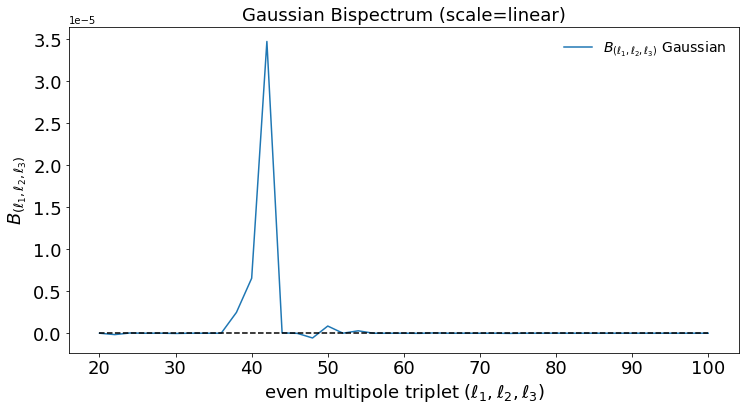

In [11]:
# bls_list = [bls_gauss, bls_nongauss]
bls_labels = ["$B_{(\ell_1, \ell_2, \ell_3)}$ Gaussian", "$B_{(\ell_1, \ell_2, \ell_3)}$ Non-Gaussian"]

xlmin = 20
xlmax = None

plot_bispec_eq([bls_gauss], labels=[bls_labels[0]], xlmin=xlmin, xlmax=xlmax, title="Gaussian Bispectrum (scale=linear)")
# plot_bispec_eq(bls_list, labels=bls_labels, xlmin=xlmin, xlmax=xlmax, title="Gaussian vs. Non-Gaussian Bispectrum (scale=linear)")

In [12]:
lmax = 250
sorted_alms = sort_alms(hp.map2alm(bls_gauss_map), lmax+1)

In [13]:
# check_locs = np.arange(50, 500+1, 50)
# percent_avg = np.zeros_like(check_locs)

# print("Ell \t Max \t Percent")
# for i,loc in enumerate(check_locs):
#     bls_gauss_test = bispec_range(bls_gauss_map, lmax=loc, scheme='e', ell_interval=2)
#     bls_gauss_vals = np.abs(split_bls(bls_gauss_test, get='bls'))
#     max_val_loc = int(np.argwhere(bls_gauss_vals == np.max(bls_gauss_vals[10:])))*2
#     percent_loc = (max_val_loc / loc) * 100
#     percent_avg[i] = percent_loc
#     print("{} \t {} \t {:.2f}%".format(loc, max_val_loc, percent_loc))

# print("Percent Average Location of Max Val: {:.2f}%".format(np.mean(percent_avg)))

In [31]:
def run_over_maps(seed_start=160989, nmaps=10, ells=np.arange(1,1024,1), ls=np.array([100,200])):
    lmax = np.max(ells)
    cls = (ells+0.0)**(-3.)
    # wig.wig_table_init((lmax+1)*2, 3)
    # wig.wig_temp_init((lmax+1)*2)
    bls_maps = np.zeros((nmaps, len(ls)), dtype='float')
    for i in tqdm(range(nmaps)):
        np.random.seed(seed_start+i)
        theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=lmax, alm=True)
        sorted_alms = sort_alms(alms, lmax+1)
        bls = np.zeros_like(l, dtype='float')
        for j,l in enumerate(ls):
            bls[j] = compute_bispec_jit(l, l, l, sorted_alms[l], sorted_alms[l], sorted_alms[l], num_threads=48)
        bls_maps[i] = bls
    # wig.wig_temp_free()
    # wig.wig_table_free()
    return l, bls_maps

In [15]:
nmaps = 10
lmin = 30
lmax = 200
bin = 10

ls = np.arange(lmin, lmax+1, bin)
ells, bls_maps = run_over_maps(ls=ls, nmaps=nmaps)

  0%|          | 0/10 [00:00<?, ?it/s]

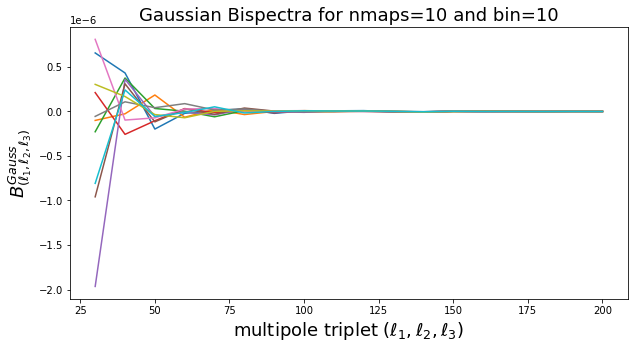

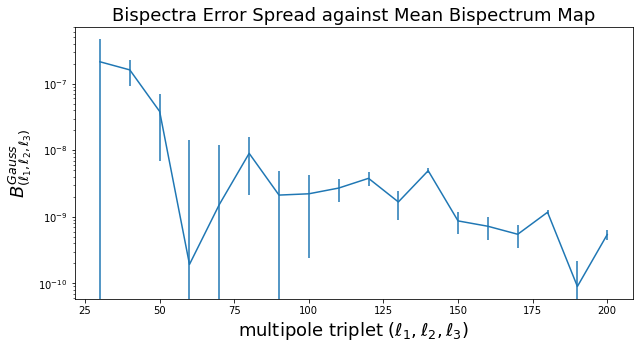

In [27]:
plt.figure(figsize=(10,5))
for i in range(nmaps):
    plt.plot(ells, bls_maps[i])
plt.title("Gaussian Bispectra for nmaps={} and bin={}".format(nmaps,bin), fontsize=18)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("$B^{Gauss}_{(\ell_1, \ell_2, \ell_3)}$", fontsize=18)
plt.show()
plt.figure(figsize=(10,5))
plt.errorbar(ells, np.abs(np.mean(bls_maps, 0)), np.std(bls_maps, 0)/np.sqrt(nmaps))
plt.title("Bispectra Error Spread against Mean Map", fontsize=18)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("$B^{Gauss}_{(\ell_1, \ell_2, \ell_3)}$", fontsize=18)
plt.yscale('log')
plt.show()

Let's look at the theoretical variance, given by:

$$ \operatorname{Var}\left(B_{\ell_{1} \ell_{2} \ell_{3}}\right)=g_{\ell_{1} \ell_{2} \ell_{3}} N_{\Delta}^{\ell_{1} \ell_{2} \ell_{3}} C_{\ell_{1}} C_{\ell_{2}} C_{\ell_{3}} \equiv V_{\ell_{1} \ell_{2} \ell_{3}} $$

such that $N_{\Delta}^{\ell_1 \ell_2 \ell_3}$ is as before, namely:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2 $$

and $g_{\ell_1 \ell_2 \ell_3}$ is equal to either 6, 2, or 1 depending on whether 3, 2, or no $\ell$'s are equal respectively. This implies that, for the equilateral case we're dealing with above, $g_{\ell_1 \ell_2 \ell_3} = 6$, giving us a variance of:

$$ V_{\ell_1 \ell_2 \ell_3} = 6 \cdot N_{\Delta}^{\ell_1 \ell_2 \ell_3} \cdot C_{\ell_1} C_{\ell_2} C_{\ell_3} $$

In [70]:
def find_bispec_var(l1, l2, l3):
    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) * (Wigner3j(l1, l2, l3, 0, 0, 0))**2
    ells = np.array([l1, l2, l3])
    cls = (ells+0.0)**(-3.)
    g = 6
    
    return g * norm_factor * np.prod(cls)


In [75]:
def find_bispec_var_binned(ls):
    bls_var = np.zeros_like(ls, dtype='float')
    xi = 0
    for i,l1 in enumerate(ls):
        for l2 in ls:
            for l3 in ls:
                xi += 1
                bls_var[i] += find_bispec_var(l1, l2, l3)

    return 6/(xi**2) * bls_var
    

In [85]:
bls_var = np.zeros_like(ls, dtype='float')

for i,l in enumerate(ls):
    bls_var[i] = find_bispec_var(l, l, l)


In [84]:
bls_var = find_bispec_var_binned(ls)

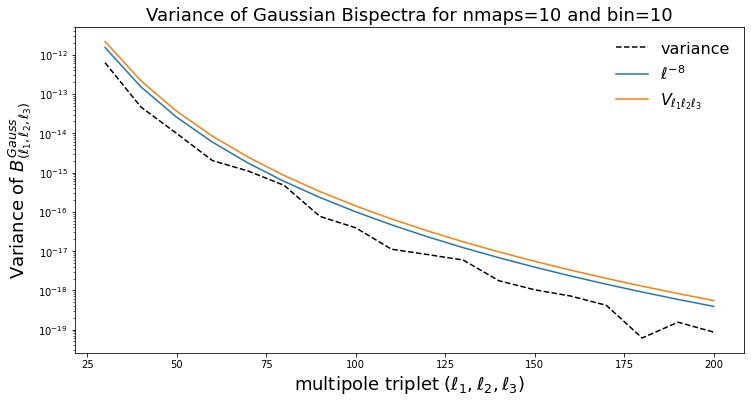

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(ells, np.std(bls_maps, 0)**2, 'k--', label="variance")
plt.plot(ells, (ells+0.0)**(-8), label="$\ell^{-8}$")
plt.plot(ells, bls_var, label="$V_{\ell_1 \ell_2 \ell_3}$")
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.title("Variance of Gaussian Bispectra for nmaps={} and bin={}".format(nmaps, bin), fontsize=18)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("Variance of $B^{Gauss}_{(\ell_1, \ell_2, \ell_3)}$", fontsize=18)
plt.yscale('log')
plt.show()